In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import sys
import re, string
import nltk, spacy, gensim
from scipy.stats.mstats import gmean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, fbeta_score 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion, Pipeline 


from numpy import dot
from numpy.linalg import norm
import pickle

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_data(data_splits):
    """
    Function that combines the DataFrame for training, validation, and test.
    """
    path = "dataset/archive/disaster_response_messages_{}.csv"
    dfs = []
    for data_split in data_splits:
        file_path = path.format(data_split)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs) #combine files for each split

In [4]:
def data_cleaning(data_df):
    """
    Function that cleans the data.
    """    
    data_df = data_df.drop_duplicates()
    return data_df 

In [5]:
def save_to_database(data_df,db_name):
    """
    Save data to database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Write dataframe to database
    data_df.to_sql('data_df',engine,if_exists='replace')
    pass 

In [6]:
def load_from_database(db_name):
    """
    Load data from database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Read dataframe from database
    data_df = pd.read_sql_table('data_df',engine)
    data_df = data_df.dropna(subset=["message"])
    X = data_df['message'].fillna(value='')
    C = data_df.iloc[:,4:]
    message_class = C.columns
    return X, C, message_class

In [7]:
def document_cleaning(data_df):
    """
    Function that cleans the document.
    """    

    data = data_df.values.tolist()                            # convert data to list
    data = [re.sub(r'\S*@\S*\s?', '', item) for item in data] # Remove email addresses
    data = [re.sub('[%s]' % re.escape(string.punctuation), ' ', item) for item in data] # Remove punctuations
    data = [re.sub(r'\s+', ' ', item) for item in data]       # Remove characters that begin a new line
    data = [re.sub(r"\'", "", item) for item in data]         # Remove single quotes
    data = [re.sub(r'\w*\d\w*', ' ', item) for item in data]  # Remove numbers
    data = [re.sub(r' +', ' ', item) for item in data]# Remove extra spaces
    data = [item.lower() for item in data]                    # Make each document lower case
    
    return data

In [8]:
def tokenize_doc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

### Load data from database

In [10]:
# Load data from database

database_name = 'disaster_response.db'
X, C, message_class = load_from_database(database_name)

# train test split
#X_train, X_test, y_train, y_test = train_test_split(X, C,test_size=.2, random_state=2018)

In [11]:
pprint(X[:1])

0    Weather update - a cold front from Cuba that c...
Name: message, dtype: object


In [12]:
pprint(message_class)

Index(['genre', 'related', 'PII', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


### Document Cleaning

In [13]:
# Document cleaning

# X = X[:100]
message_data = document_cleaning(X)
pprint(message_data[:1])

['weather update a cold front from cuba that could pass over haiti']


### Tokenize documents

In [14]:
message_words = list(tokenize_doc(message_data))
print(message_words[:2])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over']]


In [15]:
# Initialize spaCy ‘en_core_web_sm’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [16]:
def topic_prediction(text, nlp=nlp):
    global tokenize_doc
    global lemmatization
    text_doc2 = list(tokenize_doc(text))
    text_doc3 = lemmatization(text_doc2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    text_doc4 = vectorizer.transform(text_doc3)
    topic_probability_scores = model.transform(text_doc4)
    topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    infer_topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), -1]
    return infer_topic, topic, topic_probability_scores

In [17]:
def similar_corpus(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    dist = euclidean_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(dist)
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [18]:
def similar_corpus_cosine(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    #dist = cosine_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    dist = cosine_similarity(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(np.argsort(dist))
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [19]:
# Lemmatization for any choice to keep -  Noun, Adj, Verb, Adverb ['NOUN', 'ADJ', 'VERB', 'ADV']

message_lemmatized = lemmatization(message_words, allowed_postags=['NOUN', 'VERB'])

In [20]:
print(message_lemmatized[:3])

['weather update front pass', 'be hurricane be', 'look name']


In [21]:
print(message_words[:4])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'], ['looking', 'for', 'someone', 'but', 'no', 'name'], ['un', 'reports', 'leogane', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supplies', 'desperately']]


In [22]:
print(message_lemmatized[:4])

['weather update front pass', 'be hurricane be', 'look name', 'report leogane destroy hospital functioning need supply']


In [23]:
# Document word Matrix
# Document word Matrix
# Words that have occured in less than 10 documents (min_df) are cut off
# Words that have occured in more than 50% of the documents (max_df, None) are cut off
# At least 3 characters in each word
# Max number of unique words = 50000

vectorizer = TfidfVectorizer(analyzer='word',min_df=10,max_df=0.5,stop_words='english',lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',max_features=50000)
message_vectorized = vectorizer.fit_transform(message_lemmatized)

In [25]:
# LSA Model

model = TruncatedSVD(n_components=10,algorithm='randomized',n_iter=10,random_state=100,tol=0.0)
output = model.fit_transform(message_vectorized)
print(model)  # Model attributes

TruncatedSVD(n_components=10, n_iter=10, random_state=100)


In [26]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [27]:
# Dominant topics (Create Document — Topic Matrix)

topic_names = ["Topic" + str(i) for i in range(model.n_components)] # column names
doc_names = ["Doc" + str(i) for i in range(len(message_data))]               # index names
# Document — Topic Matrix dataframe
document_topic_df = pd.DataFrame(np.round(output, 2), columns=topic_names, index=doc_names)
# Get dominant topic for each document
dominant_topics = np.argmax(document_topic_df.values, axis=1)
document_topic_df["dominant_topic"] = dominant_topics

document_topics_df = document_topic_df.head(15)
document_topics_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.02,0.01,-0.02,0.01,-0.02,0.00,-0.00,0.01,-0.00,-0.01,0
Doc1,0.02,0.01,-0.02,0.02,-0.02,-0.01,0.01,0.02,0.01,-0.02,0
Doc2,0.01,0.00,-0.01,0.00,-0.01,0.00,0.00,0.00,0.01,-0.00,0
Doc3,0.16,-0.06,-0.03,-0.03,0.06,0.01,-0.01,0.11,-0.08,-0.07,0
Doc4,0.05,0.04,-0.05,0.02,-0.08,-0.03,-0.06,0.04,-0.02,-0.08,0
Doc5,0.09,0.27,0.01,-0.14,0.14,0.05,-0.24,-0.12,-0.06,0.01,1
Doc6,0.01,0.00,-0.02,0.01,-0.03,-0.01,-0.01,0.01,-0.00,-0.01,0
Doc7,0.48,-0.14,-0.09,-0.25,0.18,0.15,-0.01,0.36,0.37,-0.16,0
Doc8,0.20,0.26,0.14,-0.23,-0.33,0.31,0.14,0.04,0.30,0.01,5
Doc9,0.04,-0.01,-0.04,0.01,-0.04,-0.02,-0.03,-0.00,-0.01,-0.06,0


In [28]:
# Topic-Keyword Matrix

topic_keywords_df = pd.DataFrame(model.components_)
# Assign Column and Index
topic_keywords_df.columns = vectorizer.get_feature_names()
topic_keywords_df.index = topic_names
# View
topic_keywords_df.head()

,abandon,ability,absence,absorb,abuse,accelerate,accept,access,accident,accommodate,...,yard,year,yesterday,yield,yorker,youth,yuan,zimbabwe,zinc,zone
Topic0,0.001484,0.001111,0.000766,0.000449,0.000780,0.000431,0.002185,0.009772,0.001289,0.001007,...,0.003856,0.034041,0.005067,0.001563,0.000411,0.002559,0.000444,0.000690,0.000389,0.016917
Topic1,-0.000450,-0.000002,0.000103,-0.000245,0.000008,-0.000051,0.001574,-0.001757,0.000208,0.000219,...,-0.001439,0.017071,0.000889,-0.000378,0.000038,0.000239,0.000042,-0.000080,0.000021,0.001584
Topic2,-0.001730,-0.001723,-0.001672,-0.000918,-0.000884,-0.000916,-0.001785,-0.014877,-0.002927,-0.001684,...,0.001559,-0.044438,-0.004177,-0.003660,-0.000727,-0.000554,-0.000973,-0.001262,-0.000544,-0.012266
Topic3,0.000711,0.000251,0.000187,0.000012,0.000299,0.000128,0.000792,-0.001624,0.001640,0.000779,...,0.001672,0.037151,0.002638,0.000206,0.000376,0.000743,0.000382,0.000476,0.000155,0.001566
Topic4,-0.002408,-0.001776,-0.001649,-0.000556,-0.001857,-0.001084,-0.003002,-0.010438,-0.003242,-0.001421,...,-0.000246,-0.057823,-0.004606,-0.003078,-0.000440,-0.001672,-0.001199,-0.001813,-0.001179,-0.014296


In [29]:
# Keyword-topic Matrix for top n words

keyword_topic_df = pd.DataFrame(model.components_).T
# Assign Column and Index
keyword_topic_df.index = vectorizer.get_feature_names()
keyword_topic_df.columns = topic_names
# View
keyword_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
abandon,0.001484,-0.000450,-0.001730,0.000711,-0.002408,-0.001073,-0.002434,0.001169,-0.001373,-0.001559
ability,0.001111,-0.000002,-0.001723,0.000251,-0.001776,-0.000835,-0.001041,0.000098,0.000341,-0.002518
absence,0.000766,0.000103,-0.001672,0.000187,-0.001649,-0.000166,-0.000628,-0.000294,-0.000186,-0.002789
absorb,0.000449,-0.000245,-0.000918,0.000012,-0.000556,-0.000362,-0.000651,-0.000362,-0.000002,-0.002105
abuse,0.000780,0.000008,-0.000884,0.000299,-0.001857,0.000456,-0.000873,0.000504,-0.000692,-0.002086


In [30]:
# Show top n keywords for each topic

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=model, n_words=15)

# Topic - Keywords Dataframe
topic_keywords_df = pd.DataFrame(topic_keywords)
topic_keywords_df.columns = ['Word '+str(i) for i in range(topic_keywords_df.shape[1])]
topic_keywords_df.index = ['Topic '+str(i) for i in range(topic_keywords_df.shape[0])]

#Keywords-topic
keywords_topic_df = pd.DataFrame(topic_keywords).T
keywords_topic_df.columns = ['Topic '+str(i) for i in range(keywords_topic_df.shape[1])]
keywords_topic_df.index = ['Word '+str(i) for i in range(keywords_topic_df.shape[0])]

keywords_topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,need,information,help,earthquake,need,message,know,need,thank,people
Word 1,help,earthquake,like,help,information,note,like,thank,food,food
Word 2,food,like,thank,http,earthquake,send,earthquake,job,water,die
Word 3,water,know,know,bit,food,thank,food,people,send,send
Word 4,people,thank,job,people,tent,need,message,know,earthquake,card
Word 5,information,want,need,hit,bit,translate,note,tent,advance,live
Word 6,thank,http,message,haiti,http,information,http,say,http,hunger
Word 7,earthquake,bit,information,victim,water,earthquake,need,work,wait,eat
Word 8,know,haiti,want,com,haiti,person,bit,rain,bless,kill
Word 9,tent,country,ask,say,com,understand,job,sleep,answer,ask


In [31]:
# Message-Topic-Matrix
document_topic_df['message'] = message_data
document_topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,message
Doc0,0.02,0.01,-0.02,0.01,-0.02,0.00,-0.00,0.01,-0.00,-0.01,0,weather update a cold front from cuba that cou...
Doc1,0.02,0.01,-0.02,0.02,-0.02,-0.01,0.01,0.02,0.01,-0.02,0,is the hurricane over or is it not over
Doc2,0.01,0.00,-0.01,0.00,-0.01,0.00,0.00,0.00,0.01,-0.00,0,looking for someone but no name
Doc3,0.16,-0.06,-0.03,-0.03,0.06,0.01,-0.01,0.11,-0.08,-0.07,0,un reports leogane destroyed only hospital st ...
Doc4,0.05,0.04,-0.05,0.02,-0.08,-0.03,-0.06,0.04,-0.02,-0.08,0,says west side of haiti rest of the country to...
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc26211,0.02,-0.00,-0.02,0.00,-0.02,-0.01,-0.01,-0.00,0.00,-0.03,0,the training demonstrated how to enhance micro...
Doc26212,0.03,0.01,-0.02,-0.00,-0.04,0.00,-0.01,0.03,0.00,-0.05,0,a suitable candidate has been selected and och...
Doc26213,0.02,-0.00,-0.01,0.01,-0.02,-0.01,-0.01,0.01,0.00,-0.02,0,proshika operating in cox s bazar municipality...
Doc26214,0.03,0.00,-0.02,0.01,-0.04,-0.02,-0.02,0.02,-0.01,-0.02,0,some women protesting against the conduct of t...


## Topic interpretation

* ### Topic0

In [32]:
# Topic interpretation
# interpreted as: AID-FOOD,WATER

tmp_df = document_topic_df.sort_values('Topic0', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

we need help we need water tents with foods since after the earthquake we never found nothing please help us thanks 

we are in pamis aven we need help we have no food or water 

we at impasse st raphaelle need help we need sometents food and water thank you

i need help food water please 

we need food and water at sicot street in carrefour help us please 

help me i need food and water 

help us please we need some food 

we need food can you help us 

i can help with food if needed 

we need some help at croix des bouquet some reffuges have never find any food 



* ### Topic1

In [33]:
# Topic interpretation
# interpreted as: INFORMATION_REQUEST-EARTHQUAKE

tmp_df = document_topic_df.sort_values('Topic1', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

hello i would like to know more information about the earthquakes

i would like to know all the information about the past earthquakes 

i would like to know of informations about the earthquake 

please i would like to know all the information in the earthquake 

i would like to get information about the earthquake 

i would like information about the earthquake

i would like some information on the earthquake in haiti 

i would like some information on the earthquake 

i would like to have some information about the next earthquake 

i would like to get information on the earthquake 



* ### Topic2

In [34]:
# Topic interpretation
# interpreted as: REQUEST-HOW TO GET HELP

tmp_df = document_topic_df.sort_values('Topic2', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

what should i do to find some help 

is latortue not in haiti we ve gotten no help here 

what can i do to get help because i m in aquin province earrondissement 

bary mherbani meri madad ke jayee gaoon gul khan laghari talkio khair pure nathan shah distk dadu sindhi u c kandi chukhi salleb zadgan no govt no orgnization no one please help me sender

we never got any help we only kept going with the little we have but we will not be able to keep on please help us

how can do you help me please 

there is besion of l has tabarre b helps 

help me for delmas street of quosquer 

i am a surviver of the earthkaque see how you can help me

locality lafayette petit boukan gressier no help yet 



* ### Topic3

In [35]:
# Topic interpretation
# interpreted as: EARTHQUAKE_RELATED-INFORMATION,HELP

tmp_df = document_topic_df.sort_values('Topic3', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

 pleaseexplainwhy help haiti goodnight yele earthquake nowplaying liltwistloveaffair dontfollowmeif teamconan omgfacts

help haiti omgfacts dontfollowmeif nowplaying pleaseexplainwhy yele goodnight liltwistloveaffair earthquake teamconan

i nee help because of the earthquake

is the earthquake possible again 

earthquake of january 

there will always have earthquake 

so scared here in dominica republic for the earthquake s 

what s new for the earthquake 

what do i have to do when there s earthquake 

when will there be another earthquake again 



* ### Topic4

In [36]:
# Topic interpretation
# interpreted as: EARTHQUAKE_RELATED-INFORMATION

tmp_df = document_topic_df.sort_values('Topic4', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i need some information on the earthquake 

i need some informations the earthquake please 

i need information about the earthquake 

i need information on the earthquake 

i need some information on how to behave after this earthquake 

i need some information about the earthquake 

i need more information on the earthquake

sos needed information about the earthquake 

i need some information about the earthquake 

i need information on the earthquake 



* ### Topic5

In [37]:
# Topic interpretation
# interpreted as: IRRELEVANT MESSAGES

tmp_df = document_topic_df.sort_values('Topic5', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

notes this is not an important message this is not an important message

notes this message is already translate 

notes this message is nonsensical 

notes this message is not very important 

notes this is not an important message 

notes this message is not too important 

notes this message is not complete

notes this message texte is not important 

notes this sms is not an important message 

notes this message texte is not clear 



* ### Topic6

In [38]:
# Topic interpretation
# interpreted as: INFORMATION_REQUEST-EARTHQUAKE,HURRICANE

tmp_df = document_topic_df.sort_values('Topic6', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i would like to know that an earthquake again 

i would like to know if there will be another earthquake this saturday for real 

what i would like that you know 

earthquake in haiti does anyone know anything about this 

juaa f uck sandy i got my pl‚àö√ötanos and arepas ready d you already know how i am with food d

i would like to know there is not of sms current 

what s up i would like to know how the arab is doing 

i would like to know where is the refurbish planification 

i would like to know there is not of msm current 

i would like to know when they are going to do the back permanent 



* ### Topic7

In [39]:
# Topic interpretation
# interpreted as: AID-JOB,TENT,GENERAL_INFORMATION

tmp_df = document_topic_df.sort_values('Topic7', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i need goog and important informaition thank you 

ok thank you i m a professional i need a job what must i do to find it 

i am a topographe i need a job now please thanks 

we need or tents please thank you 

thank you so much but i need a tent please 

i need everything right now i am hopless 

 call me back now because i need you 

i need all the name of american superstar who did telethon for haiti

i need always some informationsplease 

i need to contuine my studies and i need a job because i am all by myself thanks 



* ### Topic8

In [40]:
# Topic interpretation
# interpreted as: AID_RELATED-APPRECIATION/SARCASM

tmp_df = document_topic_df.sort_values('Topic8', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i m a mason thank you for your patience 

thanks for everything he she will always be stable solid 

we can t find anything at all thank you 

 and all those still under the ruble thank you 

the sms ok thank you very much for all the good and infomation council that the reward from god 

below the house ok thank you for all the texts you sent for me and are sending for me still thank you thank you than you it is you who are there with me thank you don t give up on me ok thank you

thank you i am very happy i am waiting with more thanks 

i never found water of food thank you 

power s out thanks sandy thanks 

thank you at digicel s compagny i congratule you so continue with the messages because they feel me very good thank you thank you thank you 



* ### Topic9

In [41]:
# Topic interpretation
# interpreted as: AID-FOOD RELATED

tmp_df = document_topic_df.sort_values('Topic9', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

people in kolas never found food until now 

there are people whom dont have food 

where can people from st marc find food we re hungry 

is it true there s still people alive below st gerard 

why are some people who never find nothing 

we not find nothing and i have an orphanage under my responsible with all people in the street mbc imp des 

the people of mahoti re are hungry 

how is it going to be for people who have nothing at all 

simpaties to all haitian people

rin more or less people incomplete



In [42]:
# Put inferred topics into dataframe

Topics = ["AID-FOOD,WATER","INFORMATION_REQUEST-EARTHQUAKE","REQUEST-HOW TO GET HELP",\
           "EARTHQUAKE_RELATED-INFORMATION,HELP","EARTHQUAKE_RELATED-INFORMATION","IRRELEVANT MESSAGES",\
           "INFORMATION_REQUEST-EARTHQUAKE,HURRICANE","AID-JOB,TENT,GENERAL_INFORMATION","AID_RELATED-APPRECIATION/SARCASM",\
           "AID-FOOD RELATED"]
topic_keywords_df["Topics"]=Topics
topic_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,need,help,food,water,people,information,thank,earthquake,know,tent,like,send,area,live,house,"AID-FOOD,WATER"
Topic 1,information,earthquake,like,know,thank,want,http,bit,haiti,country,message,news,send,hit,happen,INFORMATION_REQUEST-EARTHQUAKE
Topic 2,help,like,thank,know,job,need,message,information,want,ask,answer,bless,student,victim,advance,REQUEST-HOW TO GET HELP
Topic 3,earthquake,help,http,bit,people,hit,haiti,victim,com,say,house,magnitude,year,flood,die,"EARTHQUAKE_RELATED-INFORMATION,HELP"
Topic 4,need,information,earthquake,food,tent,bit,http,water,haiti,com,regard,tinyurl,medicine,photo,leogane,EARTHQUAKE_RELATED-INFORMATION
Topic 5,message,note,send,thank,need,translate,information,earthquake,person,understand,work,don,receive,tent,job,IRRELEVANT MESSAGES
Topic 6,know,like,earthquake,food,message,note,http,need,bit,job,let,haiti,tent,translate,news,"INFORMATION_REQUEST-EARTHQUAKE,HURRICANE"
Topic 7,need,thank,job,people,know,tent,say,work,rain,sleep,school,make,house,port,aid,"AID-JOB,TENT,GENERAL_INFORMATION"
Topic 8,thank,food,water,send,earthquake,advance,http,wait,bless,answer,tell,card,advice,tent,bit,AID_RELATED-APPRECIATION/SARCASM
Topic 9,people,food,die,send,card,live,hunger,eat,kill,ask,lot,thank,earthquake,port,house,AID-FOOD RELATED


### Topic Prediction

In [43]:
# Predict the topic
text_doc = ["Can we get some food"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)

['help', 'food', 'water', 'people', 'information', 'thank', 'earthquake', 'know', 'tent', 'like', 'send', 'area', 'live']
AID-FOOD,WATER


### Cluster Documents within the same topic

In [44]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics
k = 10
kmeans       = KMeans(n_clusters=k, random_state=100)
kmeans_clust = kmeans.fit_predict(output)

# Build SVD model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_svd = svd_model.fit_transform(output)

# plot axes using SVD decomposition
x_val = lda_svd[:, 0]
y_val = lda_svd[:, 1]

Text(0.5, 1.0, 'Topic Clusters')

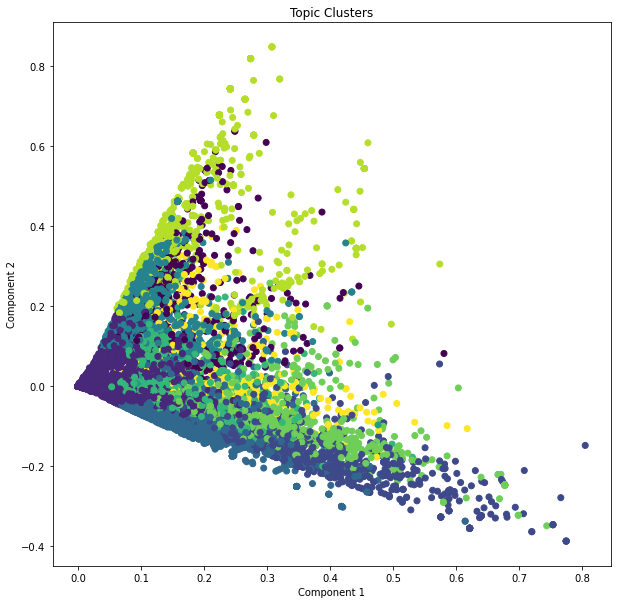

In [45]:
# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")

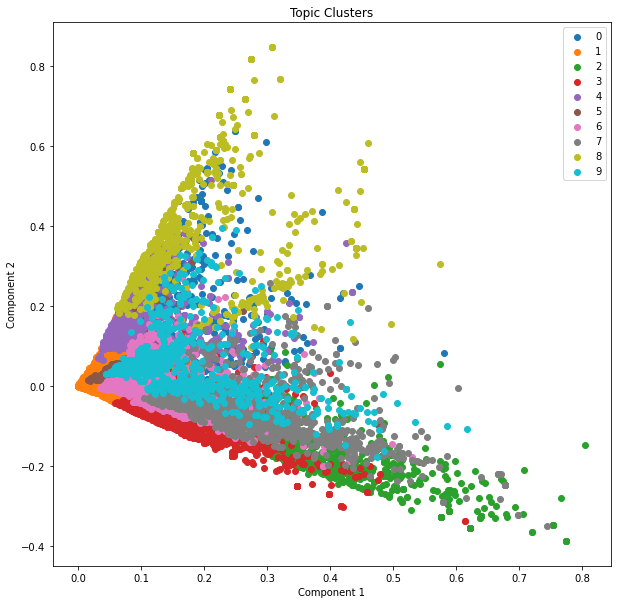

In [46]:
# Plot the cluster of points by topics

k_clusters = np.unique(kmeans_clust)
plt.figure(figsize=(10, 10))
for i in k_clusters:
    filtered_label = output[kmeans_clust == i]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], label = i)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.legend();

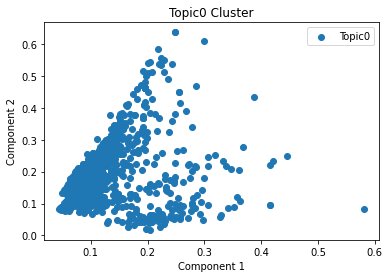

In [47]:
# Topic0 Cluster

filtered_label0 = output[kmeans_clust == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = "Topic0")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic0 Cluster")
plt.legend();

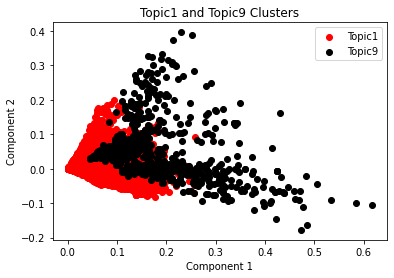

In [48]:
# Topic0 and Topic 1 Clusters
filtered_label1 = output[kmeans_clust == 1]
 
filtered_label9 = output[kmeans_clust == 9]
 
#Plotting the results
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Topic1")
plt.scatter(filtered_label9[:,0] , filtered_label9[:,1] , color = 'black', label = "Topic9")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic1 and Topic9 Clusters")
plt.legend();

### Find documents within a topic that are similar to a given document

In [49]:
# Using Euclidean distance

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
#print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus(text=text_example, doc_topic_probs=output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

AID-FOOD,WATER

 i don t need food what i need is a tarpaulin for my baby 



### Plots

In [50]:
# Plot distributions
tmp_words = []
for i in range(len(message_words)):
    tmp_words.append(len(message_words[i]))

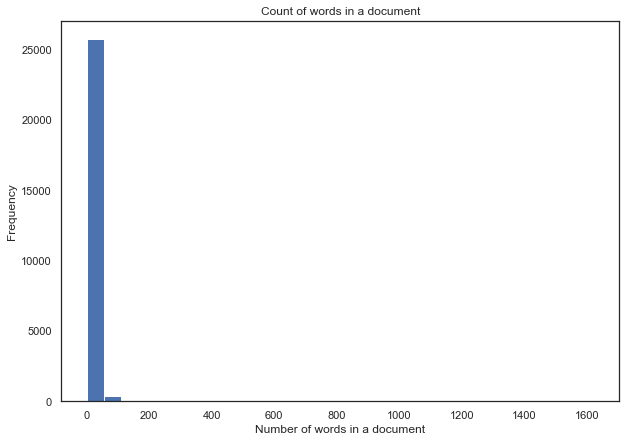

In [51]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(tmp_words,30);
ax.set_title('Count of words in a document')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of words in a document');

In [52]:
# Plots number of documents in topic

topic_list = []
topic_count = []
tot_topic = len(Topics)
for i in range(tot_topic):
    topic_l = Topics[i]
    mask = document_topic_df['dominant_topic'] == i
    topic_c = len(document_topic_df[mask])
    topic_list.append(topic_l)
    topic_count.append(topic_c)

topic_count_dict = {'Topic': topic_list, 'Count': topic_count}
topic_count_df = pd.DataFrame(topic_count_dict)
topic_count_df2 = topic_count_df.sort_values('Count', ascending = False)

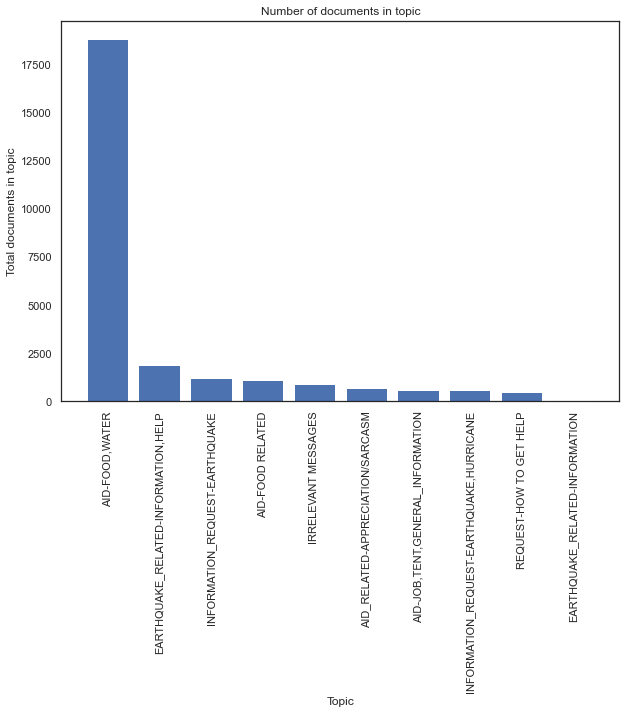

In [53]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
x_index = np.arange(topic_count_df2.Topic.count())
ax.set_xticks(ticks=x_index)

ax.bar(x_index,topic_count_df2['Count']);
ax.set_title('Number of documents in topic')
ax.set_ylabel('Total documents in topic')
ax.set_xlabel('Topic');
ax.set_xticklabels(topic_count_df2['Topic'],rotation = 90, horizontalalignment = 'center' );

### Frequency of keywords in topic

In [54]:
def flatten(outer_list):
    '''
    Function to flatten a list of list
    '''
    return [item for sublist in outer_list for item in sublist]

In [55]:
# top keywords count for Topic 0

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 0
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 0']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

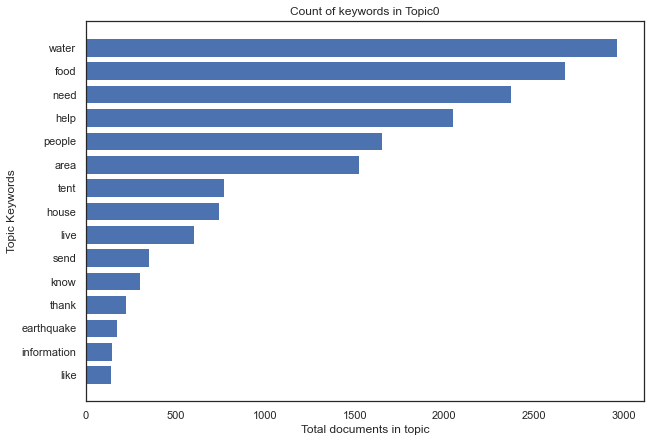

In [56]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic0')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [57]:
# top keywords count for Topic 4

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 4
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 4']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

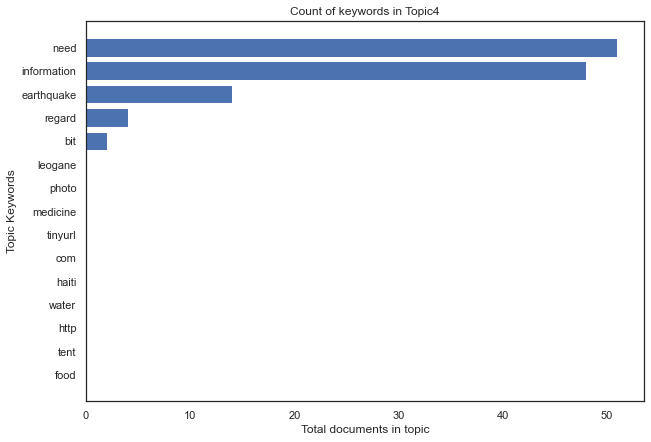

In [58]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic4')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [59]:
# top keywords count for Topic 9

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 9
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 9']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

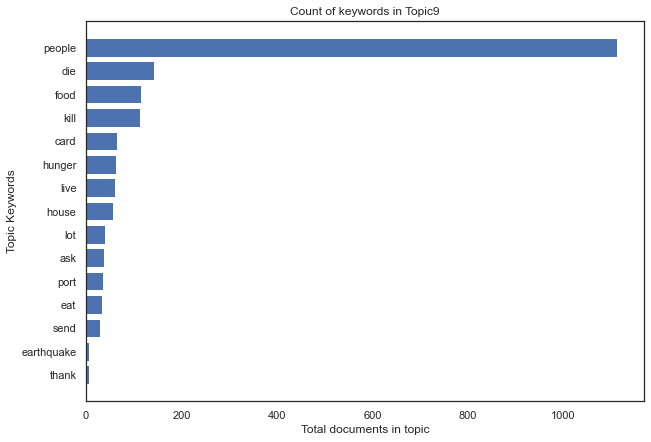

In [60]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic9')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');